In [20]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import nltk 
import re 
import os 
import json 
import swifter 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout 
from sklearn.model_selection import train_test_split 

nltk.download('stopwords') 
from nltk.corpus import stopwords 

print("Loading Yelp review data...") 
base_path = "/kaggle/input/yelp-review-polarity" 
train_path = "" 
test_path = "" 

for root, dirs, files in os.walk(base_path):
    for file in files:
        if "train" in file and file.endswith(".csv"):
            train_path = os.path.join(root, file)
        elif "test" in file and file.endswith(".csv"):
            test_path = os.path.join(root, file)

df = pd.read_csv(train_path, header=None, names=['label', 'text'])
df_test = pd.read_csv(test_path, header=None, names=['label', 'text'])
print(f"Successfully loaded {len(df)} train entries.") 
print(f"Successfully loaded {len(df)} test entries.") 
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading Yelp review data...
Successfully loaded 560000 train entries.
Successfully loaded 560000 test entries.


In [21]:
def preprocess_text(text): 
    text = text.lower() 
    text = re.sub(r'\W', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip() 
    text = ' '.join([word for word in text.split() if word not in  stop_words]) 
    return text 

In [22]:
print("Cleaning review content...") 
df['clean_text'] = df['text'].swifter.apply(preprocess_text) 
df_test['clean_text'] = df_test['text'].swifter.apply(preprocess_text) 
print("Text preprocessing complete.") 

y_train = df['label'].values - 1
y_test = df_test['label'].values - 1

Cleaning review content...


Pandas Apply:   0%|          | 0/560000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38000 [00:00<?, ?it/s]

Text preprocessing complete.


In [23]:
print("Converting text to sequences...") 
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean_text']) 
train_sequences = tokenizer.texts_to_sequences(df['clean_text']) 
test_sequences = tokenizer.texts_to_sequences(df_test['clean_text']) 
sequence_length = 100 
X_train_pad = pad_sequences(train_sequences, maxlen=sequence_length, padding='post') 
X_test_pad = pad_sequences(test_sequences, maxlen=sequence_length, padding='post') 
y_train = np.array(y_train) 
y_test = np.array(y_test) 
print("Tokenization and padding completed.") 

Converting text to sequences...
Tokenization and padding completed.


In [24]:
print("Constructing LSTM model...") 
model = Sequential([ 
    Embedding(input_dim=10000, output_dim=128),
    LSTM(128, return_sequences=True), 
    Dropout(0.5), 
    LSTM(64), 
    Dropout(0.5), 
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid') 
]) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

Constructing LSTM model...


In [25]:
print("Training the model...") 
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2) 

Training the model...
Epoch 1/5
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - accuracy: 0.7391 - loss: 0.4854 - val_accuracy: 0.9391 - val_loss: 0.1572
Epoch 2/5
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9334 - loss: 0.1708 - val_accuracy: 0.9441 - val_loss: 0.1441
Epoch 3/5
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9435 - loss: 0.1453 - val_accuracy: 0.9446 - val_loss: 0.1418
Epoch 4/5
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9535 - loss: 0.1223 - val_accuracy: 0.9426 - val_loss: 0.1449
Epoch 5/5
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9622 - loss: 0.1020 - val_accuracy: 0.9427 - val_loss: 0.1554


Evaluating on test data...


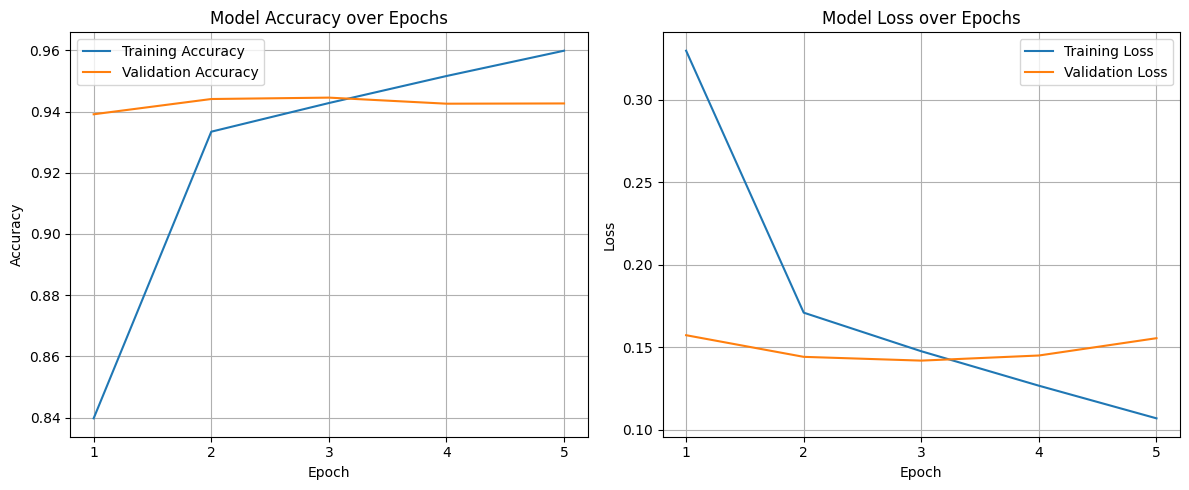

In [26]:
print("Evaluating on test data...") 
epochs_range = range(1, 6)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy') 
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy') 
plt.title('Model Accuracy over Epochs') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.xticks(epochs_range)
plt.legend() 
plt.grid(True) 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss') 
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss') 
plt.title('Model Loss over Epochs') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.xticks(epochs_range)
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 

In [27]:
def analyze_sentiment(input_text, true_label=None): 
    cleaned = preprocess_text(input_text) 
    seq = tokenizer.texts_to_sequences([cleaned]) 
    padded = pad_sequences(seq, maxlen=sequence_length, padding='post') 
    prob = model.predict(padded)[0][0] 
    sentiment = "Positive" if prob > 0.5 else "Negative"
    print(f"Review: '{input_text}'")
    if true_label is not None:
        true_sent = "Positive" if true_label == 1 else "Negative"
        print(f"True Label: {true_sent}")
    print(f"Predicted:  {sentiment} (Probability: {prob:.4f})")

print("Sample prediction tests:") 
sample_1 = "Absolutely loved the atmosphere and the food was fantastic!"
sample_2 = "I had to wait forever and the service was terrible."
analyze_sentiment(sample_1)
analyze_sentiment(sample_2)


import random
random_indices = random.sample(range(len(df_test)), 5)

for idx in random_indices:
    text_sample = df_test['text'].iloc[idx] 
    label_sample = y_test[idx]
    analyze_sentiment(text_sample, label_sample)

Sample prediction tests:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Review: 'Absolutely loved the atmosphere and the food was fantastic!'
Predicted:  Positive (Probability: 0.9969)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Review: 'I had to wait forever and the service was terrible.'
Predicted:  Negative (Probability: 0.0008)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Review: 'greatly pains me to do this, but this one star review is not tied to the food, but the lady that brings the coffee and water...she sat a coffee cup in front of me that was obviously used...it had the sip strip down the side, and drips else where...I called her back and said the cup was dirty..she told me that it wasn't dirty, that she must have bumped it while carrying it to the table...felt the cup, and the coffee stains were definitely dry...called her back again, and she asked if I would like a new cup...YA THINK! ..wow, that really fried me that she would even bring it in the first place, then try and lie her way out of r

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Accuracy = 0.9375263157894737
Precision = 0.9355092204526404
Recall = 0.9398421052631579
F-Score = 0.9376706574249107


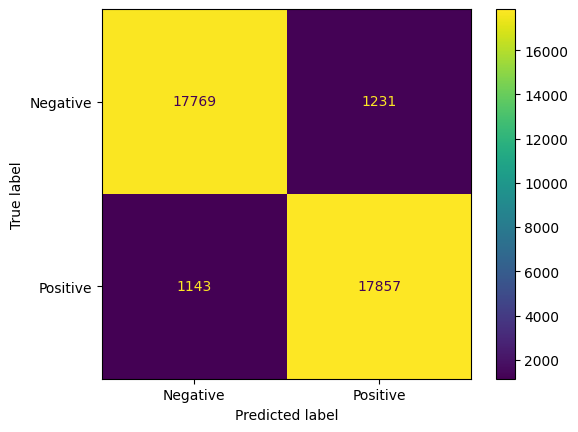

In [28]:
from sklearn import metrics

class_names = ['Negative', 'Positive']
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = y_test

cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

print(f"Accuracy = {metrics.accuracy_score(y_true, y_pred)}")
print(f"Precision = {metrics.precision_score(y_true, y_pred, average='binary')}")
print(f"Recall = {metrics.recall_score(y_true, y_pred, average='binary')}")
print(f"F-Score = {metrics.f1_score(y_true, y_pred, average='binary')}")

cm_display.plot()
plt.show()